# Задание

1) Подберите оптимальные параметры для сети из примера  (2 балла)

2) Попробуйте вместо GraphSage модуль Graph Attention и также подберите оптимальные параметры  (2 балла)


ФИО: Филимонов Степан Владиславович

In [1]:
!pip install numpy torch matplotlib tqdm progressbar optuna

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import optuna
import logging
import warnings
import progressbar

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T

from tqdm import tqdm
from torch.nn import Linear
from torch.optim import AdamW
from torch_geometric.nn import GATConv
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [3]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


## Решение

### 1. Подбор оптимальных параметров для GraphSage

In [4]:
dataset_path = '/tmp/'
dataset = MovieLens(root=dataset_path)
data = dataset[0].to(DEVICE)

In [5]:
data['user'].x = torch.eye(data['user'].num_nodes, device=DEVICE)
del data['user'].num_nodes
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label

In [6]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [7]:
weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight

In [8]:
def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

In [9]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [10]:
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

In [11]:
class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels, dropout=0.5):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels, dropout=dropout)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [12]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

In [13]:
@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

#### Оптимизация с Optuna

In [14]:
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 16, 128, step=16)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 100, 500, step=10)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.7)
    
    model = GNNModel(hidden_channels=hidden_channels, dropout=0.5).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    def train():
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                     train_data['user', 'movie'].edge_label_index)
        target = train_data['user', 'movie'].edge_label
        loss = weighted_mse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        return float(loss)
    
    @torch.no_grad()
    def test(data):
        model.eval()
        pred = model(data.x_dict, data.edge_index_dict,
                     data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)
    
    for epoch in range(epochs):
        train()
    val_rmse = test(val_data)
    return val_rmse

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)
print("Best hyperparameters:", study.best_params)

[I 2025-01-14 17:48:36,744] A new study created in memory with name: no-name-b73a8352-c431-444f-803e-61b4d98c8f6f
[I 2025-01-14 17:49:12,696] Trial 0 finished with value: 1.3813881874084473 and parameters: {'hidden_channels': 96, 'lr': 8.143408642789935e-05, 'epochs': 190, 'weight_decay': 3.549636324287168e-05, 'dropout': 0.5871559850083247}. Best is trial 0 with value: 1.3813881874084473.
[I 2025-01-14 17:50:53,729] Trial 1 finished with value: 1.0720205307006836 and parameters: {'hidden_channels': 128, 'lr': 0.0017643819697618168, 'epochs': 480, 'weight_decay': 0.0003305533816467406, 'dropout': 0.27493102747663095}. Best is trial 1 with value: 1.0720205307006836.
[I 2025-01-14 17:51:52,365] Trial 2 finished with value: 1.1619024276733398 and parameters: {'hidden_channels': 112, 'lr': 0.00028019339541912716, 'epochs': 290, 'weight_decay': 0.00038432170876120394, 'dropout': 0.6545832219837415}. Best is trial 1 with value: 1.0720205307006836.
[I 2025-01-14 17:52:57,195] Trial 3 finished

Best hyperparameters: {'hidden_channels': 112, 'lr': 0.007986848144744927, 'epochs': 400, 'weight_decay': 0.0011987711048520157, 'dropout': 0.3533733330615685}


#### Обучение с лучшими гиперпараметрами

In [16]:
best_params = study.best_params
model = GNNModel(best_params['hidden_channels'], dropout=0.5).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

In [17]:
epoch_list, loss_list, train_rmse_list, val_rmse_list, test_rmse_list = [], [], [], [], []
for epoch in tqdm(range(1, best_params['epochs'] + 1), desc="Training Progress", unit="epoch"):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    epoch_list.append(epoch)
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
    test_rmse_list.append(test_rmse)

Training Progress: 100%|███████████████████| 400/400 [03:37<00:00,  1.84epoch/s]


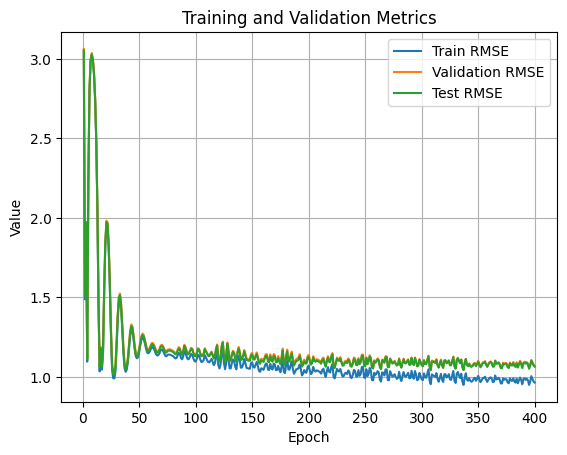

In [18]:
plt.plot(epoch_list, train_rmse_list, label='Train RMSE')
plt.plot(epoch_list, val_rmse_list, label='Validation RMSE')
plt.plot(epoch_list, test_rmse_list, label='Test RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Metrics')
plt.grid(True)
plt.show()

**Вывод:**
1. Заметно небольшое переобучение
2. Добавление `dropout`, особо не влияет

### 2. Использование Graph Attention вместо GraphSage, а также подбор параметров

In [19]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, heads=1, dropout=0.5):
        super().__init__()
        self.conv1 = GATConv(
            (-1, -1), 
            hidden_channels, 
            heads=heads, 
            dropout=dropout, 
            add_self_loops=False  # Отключаем self-loops
        )
        self.dropout = torch.nn.Dropout(p=dropout)
        self.conv2 = GATConv(
            (-1, -1), 
            out_channels, 
            heads=1, 
            concat=False, 
            dropout=dropout, 
            add_self_loops=False  # Отключаем self-loops
        )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [20]:
class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels, dropout=0.5, heads=1):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels, heads=heads, dropout=dropout)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)
    
    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [21]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

In [22]:
@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

#### Функция для Optuna

In [23]:
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 16, 128, step=16)
    heads = trial.suggest_int('heads', 1, 8)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 100, 1000, step=10)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.7)

    model = GNNModel(hidden_channels=hidden_channels, heads=heads, dropout=dropout).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    def train():
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                     train_data['user', 'movie'].edge_label_index)
        target = train_data['user', 'movie'].edge_label
        loss = weighted_mse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        return float(loss)
    
    @torch.no_grad()
    def test(data):
        model.eval()
        pred = model(data.x_dict, data.edge_index_dict,
                     data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)
    
    for epoch in range(epochs):
        train()
    val_rmse = test(val_data)
    return val_rmse

In [24]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)
print("Best hyperparameters:", study.best_params)

[I 2025-01-14 18:17:56,183] A new study created in memory with name: no-name-59c7e711-df33-4486-926a-1db4fe1a95a5
[I 2025-01-14 18:21:00,613] Trial 0 finished with value: 1.2217437028884888 and parameters: {'hidden_channels': 48, 'heads': 5, 'lr': 0.0007631734411569393, 'epochs': 800, 'weight_decay': 3.4712251654201174e-06, 'dropout': 0.6428746611458563}. Best is trial 0 with value: 1.2217437028884888.
[I 2025-01-14 18:21:47,314] Trial 1 finished with value: 2.340454339981079 and parameters: {'hidden_channels': 64, 'heads': 1, 'lr': 2.918268968497232e-05, 'epochs': 370, 'weight_decay': 3.582694183145745e-06, 'dropout': 0.4736658800409542}. Best is trial 0 with value: 1.2217437028884888.
[I 2025-01-14 18:22:38,296] Trial 2 finished with value: 1.1458384990692139 and parameters: {'hidden_channels': 64, 'heads': 2, 'lr': 0.00037960071679875486, 'epochs': 300, 'weight_decay': 0.0002834773289402016, 'dropout': 0.47452867575410806}. Best is trial 2 with value: 1.1458384990692139.
[I 2025-01-

Best hyperparameters: {'hidden_channels': 16, 'heads': 1, 'lr': 0.0043026635684812395, 'epochs': 830, 'weight_decay': 0.00022033498397990052, 'dropout': 0.697776141661963}


#### Обучение с лучшими гиперпараметрами

In [25]:
best_params = study.best_params
model = GNNModel(
    hidden_channels=best_params['hidden_channels'],
    heads=best_params['heads'],
    dropout=best_params['dropout']
).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

In [26]:
epoch_list, train_rmse_list, val_rmse_list, test_rmse_list = [], [], [], []
for epoch in tqdm(range(1, best_params['epochs'] + 1), desc="Training Progress", unit="epoch"):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    epoch_list.append(epoch)
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
    test_rmse_list.append(test_rmse)

Training Progress: 100%|███████████████████| 830/830 [01:59<00:00,  6.95epoch/s]


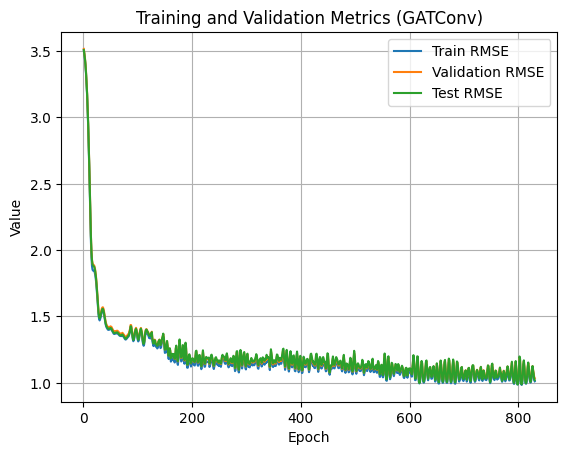

In [27]:
plt.plot(epoch_list, train_rmse_list, label='Train RMSE')
plt.plot(epoch_list, val_rmse_list, label='Validation RMSE')
plt.plot(epoch_list, test_rmse_list, label='Test RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Metrics (GATConv)')
plt.grid(True)
plt.show()

**Вывод:**

1. Видно, что разница между RMSE для тестовой, валидационной и обучающей выборок незначительны, что показывает лучший результат при использовании Graph Attention по сравнению с GraphSage.